Setup intersystems iris connection

In [3]:
import iris
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

host = "localhost"
# this is the superserver port
port = 32782
namespace = "FHIRSERVER"
user = "_SYSTEM"
password = "SYS"

conn = iris.connect(
    hostname=host,
    port=port,
    namespace=namespace,
    username=user,
    password=password
)

# create a cursor
cursor = conn.cursor()
cursor

The likelyhood of getting diabetes is altered by a number of factors including:

- Age
- Ethnicity
- Family History
- Weight
- Physical Inactivity
- Genetics
- Other Conditions: High blood pressure, high cholesterol, and heart disease increase the risk

To explore this data, I will be using synthetic patients records from [Synthea](https://synthetichealth.github.io/synthea/) using a community version of a FHIR enabled Data Platform from Intersystems called IRIS [Intersystems Open Exchange - iris-fhir-template](https://openexchange.intersystems.com/package/iris-fhir-template).
These examples are based on US population demographics and will also use a mix of LOINC and SNOMED coding, so codes used are likely to differ from UK-based systems which predominantly use SNOMED CT UK Edition.

162864005 Body mass index 30+ - obesity
408512008 Body mass index 40+ - severely obese

This focuses on data generated by the Synthea Wellness module https://github.com/synthetichealth/synthea/blob/gh-pages/graphviz/wellness_encounters.png

In [4]:


sql = """
      select patient._id, patient.KEY, DATEDIFF('year',birthdate,$HOROLOG) as AGE,
             gender,
             case gender
                 when 'male' then 1
                 when 'female' then 2
                 when 'other' then 0
                 else 9
                 end as genderUK,
             IFNULL(diabetes._id,0,1) as TYPE2DIABETES,
             IFNULL(hypertension._id,0,1) as HYPERTENSION,
             IFNULL(obese._id,0,1) as OBESE,
             IFNULL(veryobese._id,0,1) as VERY_OBESE,
             IFNULL(diabetes._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(diabetes.onsetDateStart,'YYYY-MM-DD'))) as TYPE2DIABETES_AGE,
             IFNULL(hypertension._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(hypertension.onsetDateStart,'YYYY-MM-DD'))) as HYPERTENSION_AGE,
             IFNULL(obese._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(obese.onsetDateStart,'YYYY-MM-DD'))) as OBESE_AGE,
             IFNULL(veryobese._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(veryobese.onsetDateStart,'YYYY-MM-DD'))) as VERY_OBESE_AGE
      from HSFHIR_X0001_S.Patient patient
               left outer join HSFHIR_X0001_S.Condition diabetes on patient.Key = diabetes.patient and diabetes.code [ '44054006'
               left outer join HSFHIR_X0001_S.Condition hypertension on patient.Key = hypertension.patient and hypertension.code [ '59621000'
               left outer join HSFHIR_X0001_S.Condition obese on patient.Key = obese.patient and obese.code [ '162864005'
               left outer join HSFHIR_X0001_S.Condition veryobese on patient.Key = veryobese.patient and veryobese.code [ '408512008'
      """

cursor.execute(sql)
data = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]
df = pd.DataFrame(data, columns=column_names)
pd.set_option('future.no_silent_downcasting', True)
df

,_id,Key,AGE,gender,genderUK,TYPE2DIABETES,HYPERTENSION,OBESE,VERY_OBESE,TYPE2DIABETES_AGE,HYPERTENSION_AGE,OBESE_AGE,VERY_OBESE_AGE
0,1,Patient/1,20,male,1,0,0,0,0,NaN,NaN,NaN,NaN
1,3,Patient/3,10,female,2,0,0,0,0,NaN,NaN,NaN,NaN
2,2,Patient/2,64,male,1,0,0,1,0,NaN,NaN,37.0,NaN
3,528,Patient/528,64,female,2,0,0,1,0,NaN,NaN,25.0,NaN
4,758,Patient/758,43,female,2,0,0,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,676391,Patient/676391,40,male,1,0,0,1,0,NaN,NaN,40.0,NaN
1217,676924,Patient/676924,25,male,1,0,0,1,0,NaN,NaN,12.0,NaN
1218,677181,Patient/677181,6,female,2,0,0,0,0,NaN,NaN,NaN,NaN
1219,677683,Patient/677683,76,female,2,0,1,0,0,NaN,18.0,NaN,NaN


In the preceeding display we can the AGE results have are being skewed by patients who don't have the condition. What we need to do is assign these patients a 'none' value.

Note: using null in the SQL query has automated this. So next step isn't necessary

In [5]:
df['TYPE2DIABETES_AGE'] = df['TYPE2DIABETES_AGE'].replace(-1, pd.NA).fillna(0).astype(int)
df['HYPERTENSION_AGE'] = df['HYPERTENSION_AGE'].replace(-1, pd.NA).fillna(0).astype(int)
df

,_id,Key,AGE,gender,genderUK,TYPE2DIABETES,HYPERTENSION,OBESE,VERY_OBESE,TYPE2DIABETES_AGE,HYPERTENSION_AGE,OBESE_AGE,VERY_OBESE_AGE
0,1,Patient/1,20,male,1,0,0,0,0,0,0,NaN,NaN
1,3,Patient/3,10,female,2,0,0,0,0,0,0,NaN,NaN
2,2,Patient/2,64,male,1,0,0,1,0,0,0,37.0,NaN
3,528,Patient/528,64,female,2,0,0,1,0,0,0,25.0,NaN
4,758,Patient/758,43,female,2,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,676391,Patient/676391,40,male,1,0,0,1,0,0,0,40.0,NaN
1217,676924,Patient/676924,25,male,1,0,0,1,0,0,0,12.0,NaN
1218,677181,Patient/677181,6,female,2,0,0,0,0,0,0,NaN,NaN
1219,677683,Patient/677683,76,female,2,0,1,0,0,0,18,NaN,NaN


Some of the values in the last section are wrong or nonsense, I will correct that later.

The mean AGE values are correct. This is visible in the diagram below.

gender
female    Axes(0.125,0.11;0.775x0.77)
male      Axes(0.125,0.11;0.775x0.77)
Name: AGE, dtype: object

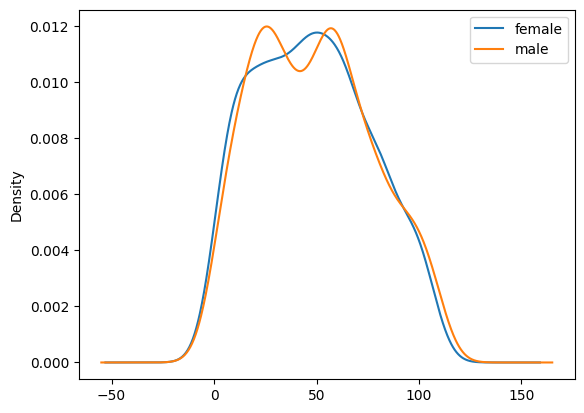

In [6]:
df.groupby('gender').AGE.plot(kind='kde',legend=True)

TYPE2DIABETES

,gender,TYPE2DIABETES_AGE,TYPE2DIABETES,_id,Key
19,male,25,1,4805,Patient/4805
20,male,40,1,5477,Patient/5477
50,female,25,1,22622,Patient/22622
56,male,31,1,27112,Patient/27112
71,male,34,1,34051,Patient/34051
...,...,...,...,...,...
1128,female,25,1,628354,Patient/628354
1139,male,28,1,636377,Patient/636377
1169,female,34,1,649454,Patient/649454
1209,female,42,1,673217,Patient/673217


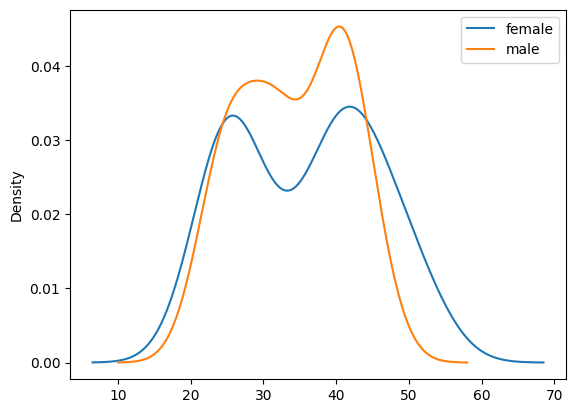

In [7]:
dfDiabetes = df[['gender','TYPE2DIABETES_AGE','TYPE2DIABETES','_id','Key']].query('TYPE2DIABETES == 1')
dfDiabetes.groupby('gender').TYPE2DIABETES_AGE.plot(kind='kde',legend=True)

dfDiabetes

,gender,OBESE_AGE,OBESE,_id,Key
2,male,37.0,1,2,Patient/2
3,female,25.0,1,528,Patient/528
14,male,9.0,1,4164,Patient/4164
20,male,15.0,1,5477,Patient/5477
26,female,28.0,1,8537,Patient/8537
...,...,...,...,...,...
1213,female,44.0,1,673892,Patient/673892
1214,female,42.0,1,675451,Patient/675451
1215,female,28.0,1,675618,Patient/675618
1216,male,40.0,1,676391,Patient/676391


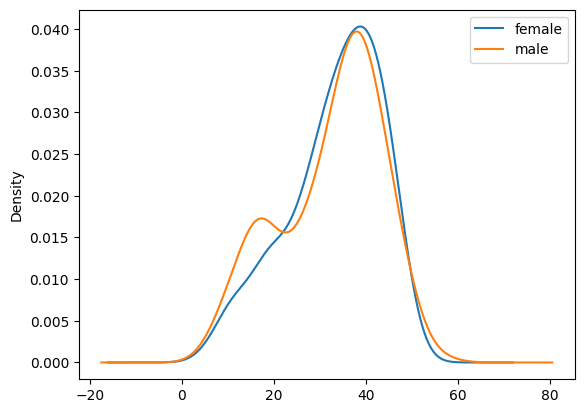

In [8]:
dfDiabetes = df[['gender','OBESE_AGE','OBESE','_id','Key']].query('OBESE == 1')
dfDiabetes.groupby('gender').OBESE_AGE.plot(kind='kde',legend=True)

dfDiabetes

We are missing ethnic, race, and birth sex from our dataset. This includes a concept in FHIR called FHIRPath and this is demonstrated in another workbook.


In [9]:
sql = """
      select patient._id, patient.KEY, DATEDIFF('year',birthdate,$HOROLOG) as AGE,
             gender,
             case gender
                 when 'male' then 1
                 when 'female' then 2
                 when 'other' then 0
                 else 9
                 end as genderUK,
             IFNULL(diabetes._id,0,1) as TYPE2DIABETES,
             IFNULL(hypertension._id,0,1) as HYPERTENSION,
             IFNULL(obese._id,0,1) as OBESE,
             IFNULL(veryobese._id,0,1) as VERY_OBESE,
             IFNULL(diabetes._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(diabetes.onsetDateStart,'YYYY-MM-DD'))) as TYPE2DIABETES_AGE,
             IFNULL(hypertension._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(hypertension.onsetDateStart,'YYYY-MM-DD'))) as HYPERTENSION_AGE,
             IFNULL(obese._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(obese.onsetDateStart,'YYYY-MM-DD'))) as OBESE_AGE,
             IFNULL(veryobese._id,null,DATEDIFF('year',TO_DATE(birthdate,'YYYY-MM-DD'),TO_DATE(veryobese.onsetDateStart,'YYYY-MM-DD'))) as VERY_OBESE_AGE
              , GetFHIRPathOne(ResourceString, 'Patient.extension(''http://hl7.org/fhir/us/core/StructureDefinition/us-core-race'').extension(''ombCategory'').valueCoding.display','Patient') Race
              , GetFHIRPathOne(ResourceString, 'Patient.extension(''http://hl7.org/fhir/us/core/StructureDefinition/us-core-race'').extension(''ombCategory'').valueCoding.code','Patient') RaceCode
              , GetFHIRPathOne(ResourceString, 'Patient.extension(''http://hl7.org/fhir/us/core/StructureDefinition/us-core-ethnicity'').extension(''ombCategory'').valueCoding.display','Patient') Ethnic
              , GetFHIRPathOne(ResourceString, 'Patient.extension(''http://hl7.org/fhir/us/core/StructureDefinition/us-core-ethnicity'').extension(''ombCategory'').valueCoding.code','Patient') EthnicCode
              , GetFHIRPathOne(ResourceString, 'Patient.extension(''http://hl7.org/fhir/us/core/StructureDefinition/us-core-birthsex'').valueCode', 'Patient') BirthSex

      from HSFHIR_X0001_S.Patient patient
               join HSFHIR_X0001_R.Rsrc resource on resource.ResourceType = 'Patient' and resource.Key = patient.Key
               left outer join HSFHIR_X0001_S.Condition diabetes on patient.Key = diabetes.patient and diabetes.code [ '44054006'
               left outer join HSFHIR_X0001_S.Condition hypertension on patient.Key = hypertension.patient and hypertension.code [ '59621000'
               left outer join HSFHIR_X0001_S.Condition obese on patient.Key = obese.patient and obese.code [ '162864005'
               left outer join HSFHIR_X0001_S.Condition veryobese on patient.Key = veryobese.patient and veryobese.code [ '408512008'
      """

cursor.execute(sql)
data = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]
df = pd.DataFrame(data, columns=column_names)
pd.set_option('future.no_silent_downcasting', True)
df

,_id,Key,AGE,gender,genderUK,TYPE2DIABETES,HYPERTENSION,OBESE,VERY_OBESE,TYPE2DIABETES_AGE,HYPERTENSION_AGE,OBESE_AGE,VERY_OBESE_AGE,Race,RaceCode,Ethnic,EthnicCode,BirthSex
0,1,Patient/1,20,male,1,0,0,0,0,NaN,NaN,NaN,NaN,White,2106-3,Not Hispanic or Latino,2186-5,M
1,2,Patient/2,64,male,1,0,0,1,0,NaN,NaN,37.0,NaN,White,2106-3,Not Hispanic or Latino,2186-5,M
2,3,Patient/3,10,female,2,0,0,0,0,NaN,NaN,NaN,NaN,White,2106-3,Not Hispanic or Latino,2186-5,F
3,528,Patient/528,64,female,2,0,0,1,0,NaN,NaN,25.0,NaN,White,2106-3,Not Hispanic or Latino,2186-5,F
4,745,Patient/745,68,female,2,0,1,0,0,NaN,18.0,NaN,NaN,White,2106-3,Not Hispanic or Latino,2186-5,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,676391,Patient/676391,40,male,1,0,0,1,0,NaN,NaN,40.0,NaN,White,2106-3,Not Hispanic or Latino,2186-5,M
1217,676924,Patient/676924,25,male,1,0,0,1,0,NaN,NaN,12.0,NaN,White,2106-3,Not Hispanic or Latino,2186-5,M
1218,677181,Patient/677181,6,female,2,0,0,0,0,NaN,NaN,NaN,NaN,White,2106-3,Not Hispanic or Latino,2186-5,F
1219,677683,Patient/677683,76,female,2,0,1,0,0,NaN,18.0,NaN,NaN,Black or African American,2054-5,Not Hispanic or Latino,2186-5,F


In [10]:
dfObesity = df[['Ethnic','Race','gender','genderUK','OBESE_AGE','OBESE','_id','Key']].query('OBESE == 1')

dfObesity

,Ethnic,Race,gender,genderUK,OBESE_AGE,OBESE,_id,Key
1,Not Hispanic or Latino,White,male,1,37.0,1,2,Patient/2
3,Not Hispanic or Latino,White,female,2,25.0,1,528,Patient/528
15,Not Hispanic or Latino,White,male,1,9.0,1,4164,Patient/4164
20,Not Hispanic or Latino,Black or African American,male,1,15.0,1,5477,Patient/5477
26,Not Hispanic or Latino,White,female,2,28.0,1,8537,Patient/8537
...,...,...,...,...,...,...,...,...
1210,Hispanic or Latino,Asian,female,2,44.0,1,673892,Patient/673892
1214,Not Hispanic or Latino,White,female,2,42.0,1,675451,Patient/675451
1215,Not Hispanic or Latino,White,female,2,28.0,1,675618,Patient/675618
1216,Not Hispanic or Latino,White,male,1,40.0,1,676391,Patient/676391


Ethnic
Hispanic or Latino        Axes(0.125,0.11;0.775x0.77)
Not Hispanic or Latino    Axes(0.125,0.11;0.775x0.77)
Name: OBESE_AGE, dtype: object

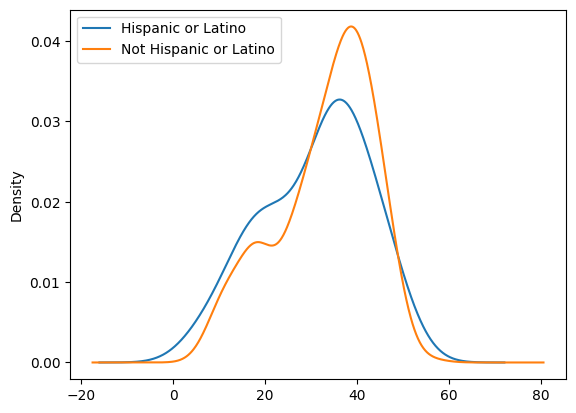

In [11]:
dfObesity.groupby('Ethnic').OBESE_AGE.plot(kind='kde',legend=True)


Race
American Indian or Alaska Native    Axes(0.125,0.11;0.775x0.77)
Asian                               Axes(0.125,0.11;0.775x0.77)
Black or African American           Axes(0.125,0.11;0.775x0.77)
White                               Axes(0.125,0.11;0.775x0.77)
Name: OBESE_AGE, dtype: object

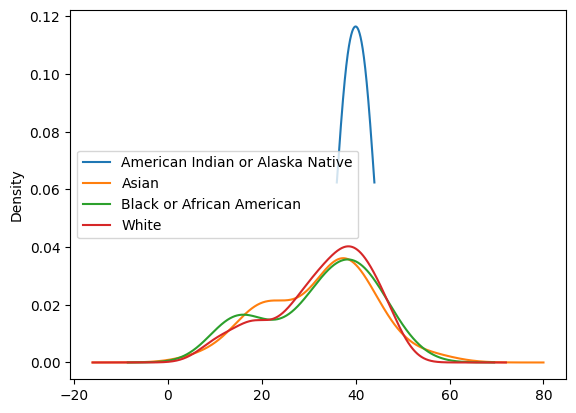

In [12]:
dfObesity.groupby('Race').OBESE_AGE.plot(kind='kde',legend=True)


Data points per race group:
                                  count
Race                                   
American Indian or Alaska Native      1
Asian                                14
Black or African American            24
White                               150


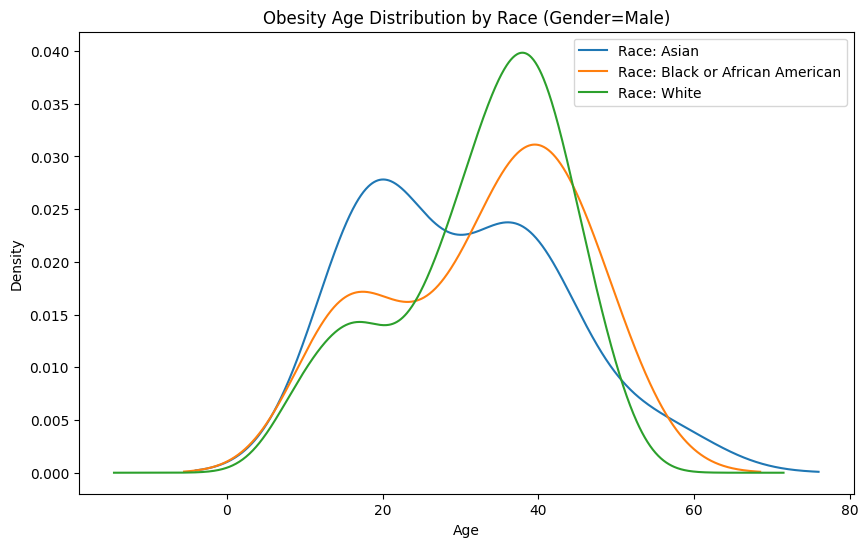

In [13]:
grouped_data = dfObesity.query('genderUK == 1').groupby('Race')['OBESE_AGE'].agg(['count'])
print("Data points per race group:")
print(grouped_data)

# Modified plotting code with error handling
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

for name, group in dfObesity.query('genderUK == 1').groupby('Race'):
    if len(group['OBESE_AGE']) > 1:  # Only plot if we have more than one data point
        group['OBESE_AGE'].plot(kind='kde', ax=ax, label=f'Race: {name}')

plt.title('Obesity Age Distribution by Race (Gender=Male)')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()


Data points per race group:
                                  count
Race                                   
American Indian or Alaska Native      1
Asian                                17
Black or African American            19
White                               152


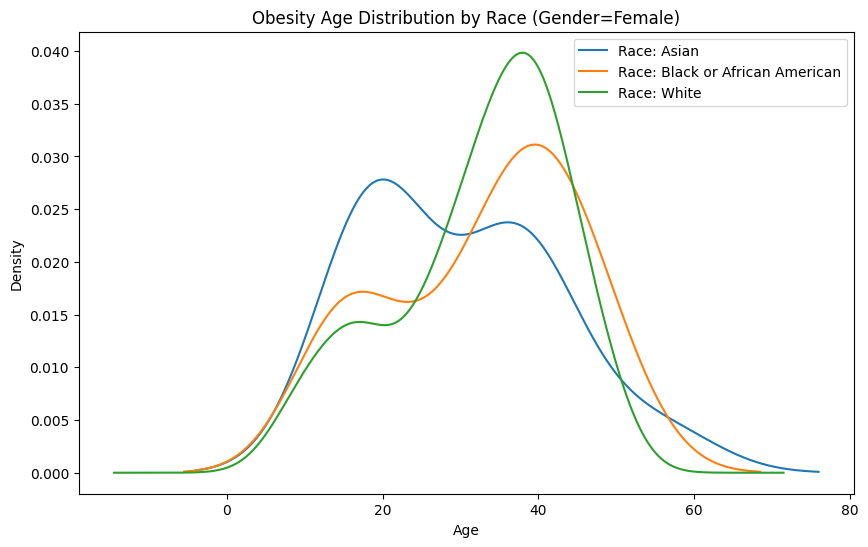

In [14]:
grouped_data = dfObesity.query('genderUK == 2').groupby('Race')['OBESE_AGE'].agg(['count'])
print("Data points per race group:")
print(grouped_data)

# Modified plotting code with error handling
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

for name, group in dfObesity.query('genderUK == 1').groupby('Race'):
    if len(group['OBESE_AGE']) > 1:  # Only plot if we have more than one data point
        group['OBESE_AGE'].plot(kind='kde', ax=ax, label=f'Race: {name}')

plt.title('Obesity Age Distribution by Race (Gender=Female)')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()


In [15]:
dfDiabetes = df[['Ethnic','Race','gender','genderUK','TYPE2DIABETES_AGE','TYPE2DIABETES','_id','Key']].query('TYPE2DIABETES == 1')

Ethnic
Hispanic or Latino        Axes(0.125,0.11;0.775x0.77)
Not Hispanic or Latino    Axes(0.125,0.11;0.775x0.77)
Name: TYPE2DIABETES_AGE, dtype: object

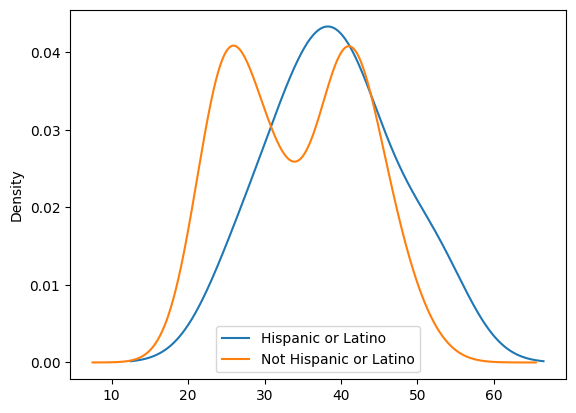

In [16]:
dfDiabetes.groupby('Ethnic').TYPE2DIABETES_AGE.plot(kind='kde',legend=True)

Most of the data so far has relied on conditions. Before we use start using Machine Learning we will enhance the dataframe to include data from
- Vital Signs Panel
- Lipid Panel

In [17]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.tree import DecisionTreeClassifier

encoder = OneHotEncoder(sparse_output=False)

diabetes = df[['Key', 'TYPE2DIABETES','EthnicCode','RaceCode','genderUK','AGE', 'HYPERTENSION','OBESE','VERY_OBESE']].copy()

diabetes['EthnicCode'] = np.where(diabetes['EthnicCode'] == '2135-2', 1, 0)

# The codes in EthnicCode represent Hispanic or Latino, or not. In the next section of code we change this to a 1 or 0.
diabetes = diabetes.rename(columns={'EthnicCode': 'LatinoHispanic'})

one_hot_encoded = encoder.fit_transform(diabetes[['RaceCode', 'genderUK']])

one_hot_df = pd.DataFrame(one_hot_encoded,
                          columns=encoder.get_feature_names_out(['RaceCode', 'genderUK']))

diabetes = pd.concat([diabetes, one_hot_df], axis=1)

diabetes = diabetes.drop(['RaceCode', 'genderUK'], axis=1)

diabetes = diabetes.rename(columns={'RaceCode_1002-5': 'AmericanIndianOrAlaskaNative', 'RaceCode_2054-5':'BlackOrAfricanAmerican','RaceCode_2106-3':'White', 'RaceCode_2028-9':'Asian' })

diabetes = diabetes.rename(columns={'genderUK_1':"Male",'genderUK_2':'Female' })

list(diabetes)


['Key',
 'TYPE2DIABETES',
 'LatinoHispanic',
 'AGE',
 'HYPERTENSION',
 'OBESE',
 'VERY_OBESE',
 'AmericanIndianOrAlaskaNative',
 'Asian',
 'BlackOrAfricanAmerican',
 'White',
 'RaceCode_UNK',
 'Male',
 'Female']

Add Lipid Panel Data

In [ ]:
sql = """
      select LDL.patient Key,
          max(LDLvalue.value) LDLCholesterol,
          max(HDLvalue.value) HDLCholesterol,
          max(Totalvalue.value) Cholesterol
      from HSFHIR_X0001_S.Observation LDL
          join HSFHIR_X0001_S_Observation.valueQuantity LDLvalue on LDL.Key = LDLvalue.Key
          join HSFHIR_X0001_S.Observation HDL on LDL.patient = HDL.patient and HDL.code [ '2085-9'
          join HSFHIR_X0001_S_Observation.valueQuantity HDLvalue on HDL.Key = HDLvalue.Key
          join HSFHIR_X0001_S.Observation Total on LDL.patient = Total.patient and Total.code [ '2093-3'
          join HSFHIR_X0001_S_Observation.valueQuantity Totalvalue on Total.Key = Totalvalue.Key
      where (LDL.code [ '18262-6')
      group by LDL.patient
"""

cursor.execute(sql)
data = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]
lipid = pd.DataFrame(data, columns=column_names)
pd.set_option('future.no_silent_downcasting', True)

mdiabetes = pd.merge(diabetes, lipid, on='Key', how='outer')


In [264]:
sql = """
   select BMI.patient Key,
max(BMIvalue.value) BMI
from HSFHIR_X0001_S.Observation BMI
join HSFHIR_X0001_S_Observation.valueQuantity BMIvalue on BMI.Key = BMIvalue.Key
where (BMI.code [ '39156-5')
group by BMI.patient
"""

cursor.execute(sql)
data = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]
bmi = pd.DataFrame(data, columns=column_names)
pd.set_option('future.no_silent_downcasting', True)

mdiabetes = pd.merge(mdiabetes, bmi, on='Key', how='outer')

In [265]:
mdiabetes = mdiabetes.drop(['Key'], axis=1)

mdiabetes

,TYPE2DIABETES,LatinoHispanic,AGE,HYPERTENSION,OBESE,VERY_OBESE,AmericanIndianOrAlaskaNative,Asian,BlackOrAfricanAmerican,White,RaceCode_UNK,Male,Female,LDLCholesterol,HDLCholesterol,Cholesterol,BMI
0,0,1,1,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN
1,0,0,64,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,145.38,79.71,205.11,32.89
2,0,0,33,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,93.96,71.12,193.05,30.41
3,0,1,75,1,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,94,78.01,199.81,26.72
4,0,0,61,0,1,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,94.31,76.37,193.37,30.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382,0,0,41,1,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,89.21,74.11,187.06,28.58
2383,0,0,53,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,105.08,70.01,197.71,3E+1
2384,0,0,13,0,1,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,30.65
2385,0,0,57,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,111.03,69.45,198.82,30.36


**Decision Tree**

In [266]:
X = mdiabetes.copy()
X = X.drop(['TYPE2DIABETES'], axis=1)
Y = mdiabetes.TYPE2DIABETES

# First, handle the missing values
# Option 1: Fill NaN with median values
X = X.fillna(X.median())

dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X,Y)

DecisionTreeClassifier(max_depth=5)

/Users/kevinmayfield/github/Phython/Play/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data

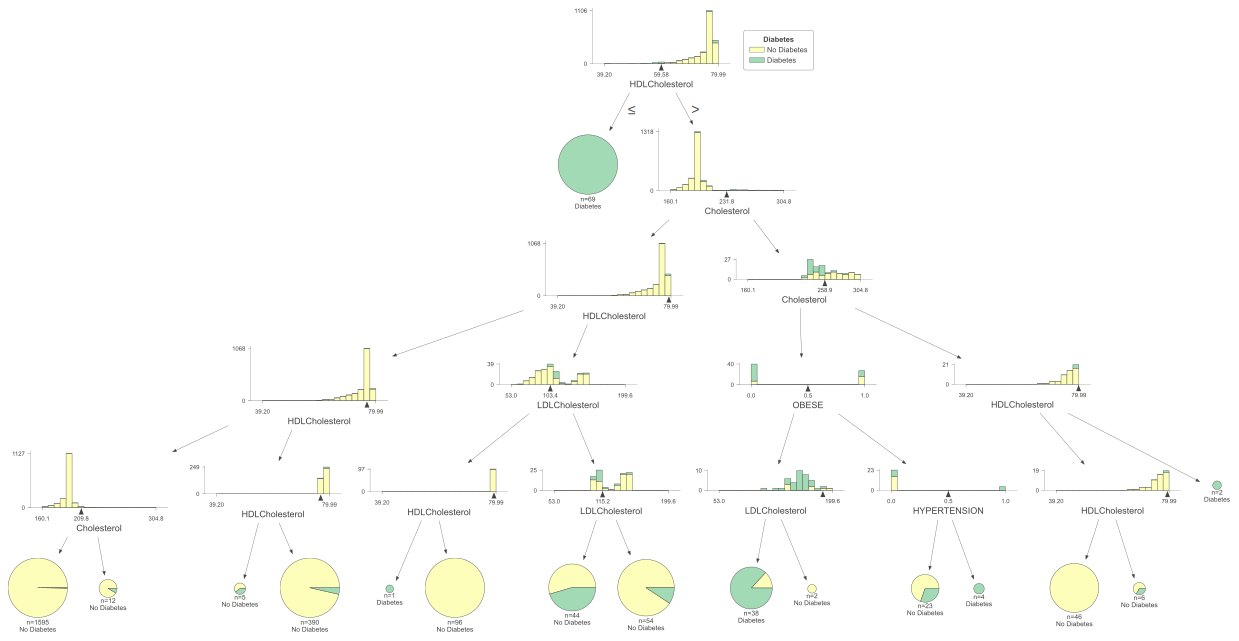

In [267]:
import dtreeviz

X = X.astype(float)

viz_model = dtreeviz.model(dt,
                           X_train=X, y_train=Y,
                           feature_names=X.columns,
                           target_name='Diabetes',
                           class_names=['No Diabetes', 'Diabetes'])

viz_model.view()

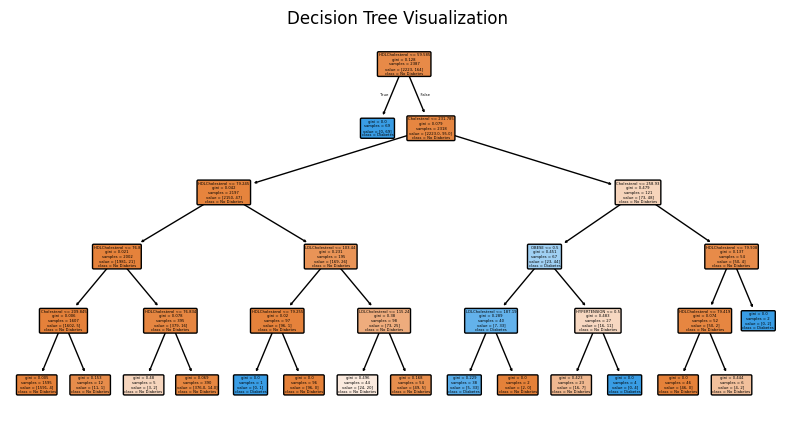

In [268]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Assuming you have your decision tree model 'dt', and data X, Y
plt.figure(figsize=(10,5))
plot_tree(dt, feature_names=X.columns, class_names=['No Diabetes', 'Diabetes'],
          filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

**Random Forest Generator**

In [269]:
np.random.seed(42)
train = (mdiabetes.groupby('TYPE2DIABETES')
         .apply(lambda x: x.sample(frac=.7))
         .reset_index(drop=True))

test = mdiabetes[~mdiabetes.index.isin(train.index)]

X_train = train.iloc[:,1:]
y_train = train.iloc[:,0]

X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]

/var/folders/16/bplm70c55mj7020_2tms62sh0000gn/T/ipykernel_59838/4053522561.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [270]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

series = [10, 25, 50, 100, 150, 200, 250, 300, 500]

test_scores = list()
for param in series:
    rf = RandomForestRegressor(n_estimators=param,
                               max_depth=14,
                               random_state=42,
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    test_scores.append(mean_absolute_error(y_test, preds))

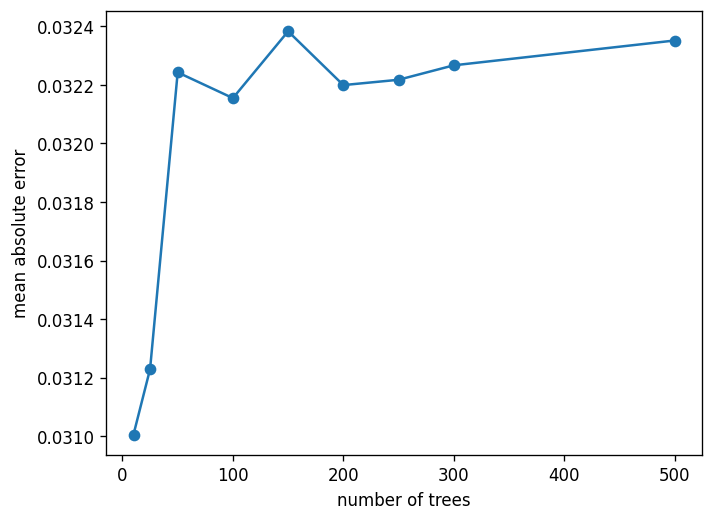

In [271]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=120)
plt.plot(series, test_scores, '-o')
plt.xlabel('number of trees')
plt.ylabel('mean absolute error')
plt.show()

In [272]:
from sklearn.inspection import permutation_importance
rf = RandomForestRegressor(n_estimators=500,
                           max_features='sqrt',
                           random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=500, random_state=42)

In [273]:
preds = rf.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print(f"test mean absolute error for rf: {mae:0.3}")

test mean absolute error for rf: 0.0339


In [274]:
result = permutation_importance(rf, X_test,
                                y_test, n_repeats=10, random_state=42, n_jobs=-1)

/var/folders/16/bplm70c55mj7020_2tms62sh0000gn/T/ipykernel_59838/141033891.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


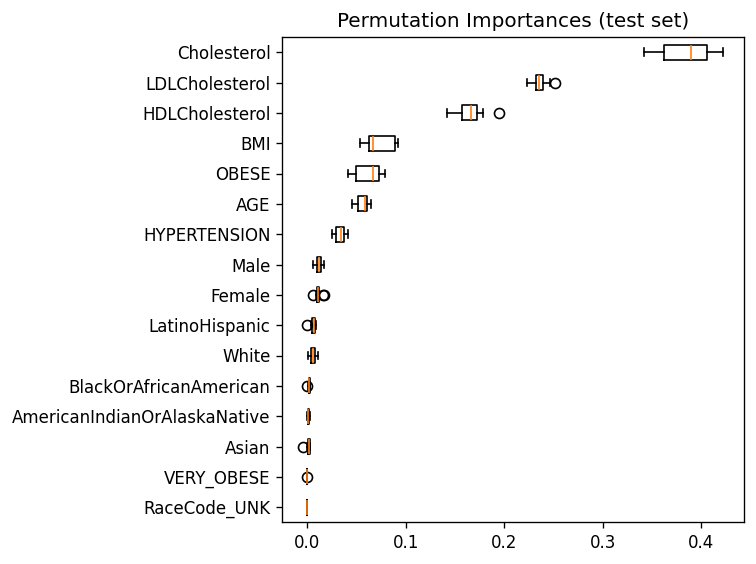

In [275]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(dpi=120)
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [276]:
conn.close()
conn

In [277]:
cursor.isClosed()
cursor